In [26]:
!date

Fri Jul 30 10:03:26 PDT 2021


# Isoform atlas

In [27]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

def nd(arr):
    return np.asarray(arr).reshape(-1)

import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [28]:
subclass_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

subclass_order = [
#    "L5 IT",
    "L5/6 NP",
    "L5 PT", 
    "L2/3 IT",
    "L6b",
    "L6 IT",
    "L6 CT",
    "L6 IT Car3",
    "Lamp5",
    "Sncg",
    "Vip",
    "Sst",
    "Pvalb",
#     "VLMC",
#     "Endo",
#     "Astro",
#     "SMC"
]

In [29]:
subclass_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [30]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [31]:
markers = pd.concat([pd.read_csv("../../tables/unordered/subclass_DE_isoform_only-GLUT.csv", index_col=0), pd.read_csv("../../tables/unordered/subclass_DE_isoform_only-GABA.csv", index_col=0)])

In [32]:
markers["index"].value_counts()

L2/3 IT ENTl     3585
CA3              3507
SUB-ProS         2811
L5 IT TPE-ENT    2740
CA1-ProS         2511
L2  IT ENTl      2342
L3 IT ENT        2084
L4/5 IT CTX      1975
L2/3 IT CTX      1934
Sncg             1924
L5 IT CTX        1899
L4 RSP-ACA       1652
L6b CTX          1512
L6 IT CTX        1351
L6 CT CTX        1350
Sst              1349
Car3             1300
L5 PT CTX        1269
Lamp5            1223
NP SUB           1042
L5 NP CTX         943
L6b/CT ENT        887
L6 IT ENTl        857
Pvalb             747
L2 IT ENTm        736
L2/3 IT RHP       609
DG                556
CT SUB            389
NP PPP            370
IG-FC             368
Sst Chodl         335
L2/3 IT PPP       281
Vip               277
L5 PPP             85
Meis2              84
CR                 65
Name: index, dtype: int64

## We remove ATP synthase isoforms as well as lincRNA , as they are not relevant to the analysis. 

In [33]:
markers = markers[np.logical_and(~markers["name"].str.contains("Atp"), ~markers["name"].str.contains("AC130815.2"))]

In [34]:
features = isoform.var.transcript_name.values

In [35]:
mtx = isoform.layers["norm"].todense()
markers["exp"] = markers.name.apply(lambda x: mtx[:,isoform.var.transcript_name==x].mean())

In [36]:
# markers.iloc[markers.groupby("index")["exp"].apply(np.argmax)]

In [37]:
def pick_top(l):
    idx = [np.where(features==i)[0][0] for i in l]

    argmax = np.argmax(nd(isoform.layers["norm"].mean(axis=0))[idx])
    return argmax

In [38]:
%%time
top = markers.groupby("index")['name'].apply(lambda x: list(x)[0:20][pick_top(list(x)[0:20])])

CPU times: user 2min, sys: 1min 15s, total: 3min 16s
Wall time: 3min 16s


In [39]:
top

index
CA1-ProS           Sdhd-201_ENSMUST00000000175.6
CA3                Sdhd-201_ENSMUST00000000175.6
CR                Pgam1-201_ENSMUST00000011896.8
CT SUB            Calm1-203_ENSMUST00000127300.2
Car3              Calm1-203_ENSMUST00000127300.2
DG               Calm1-202_ENSMUST00000110082.11
IG-FC             Cct3-201_ENSMUST00000001452.14
L2  IT ENTl      Ckmt1-201_ENSMUST00000000317.13
L2 IT ENTm        Cox5a-201_ENSMUST00000000090.8
L2/3 IT CTX       Cox5a-201_ENSMUST00000000090.8
L2/3 IT ENTl     Ckmt1-201_ENSMUST00000000317.13
L2/3 IT PPP       Cox5a-201_ENSMUST00000000090.8
L2/3 IT RHP       Calm1-203_ENSMUST00000127300.2
L3 IT ENT         Cox5a-201_ENSMUST00000000090.8
L4 RSP-ACA        Cox5a-201_ENSMUST00000000090.8
L4/5 IT CTX       Mcts1-201_ENSMUST00000000365.3
L5 IT CTX         Cox5a-201_ENSMUST00000000090.8
L5 IT TPE-ENT    Ckmt1-201_ENSMUST00000000317.13
L5 NP CTX         Cox5a-201_ENSMUST00000000090.8
L5 PPP              Id2-201_ENSMUST00000020974.7
L5 PT CTX     

In [40]:
#top = top.drop("Low Quality")
#top = top[subclass_order]
top_idx = [np.where(isoform.var.transcript_name == i)[0][0] for i in top]
top_name = ["".join(i.split("_")[:-1]) for i in top]

In [41]:
top_name

['Sdhd-201',
 'Sdhd-201',
 'Pgam1-201',
 'Calm1-203',
 'Calm1-203',
 'Calm1-202',
 'Cct3-201',
 'Ckmt1-201',
 'Cox5a-201',
 'Cox5a-201',
 'Ckmt1-201',
 'Cox5a-201',
 'Calm1-203',
 'Cox5a-201',
 'Cox5a-201',
 'Mcts1-201',
 'Cox5a-201',
 'Ckmt1-201',
 'Cox5a-201',
 'Id2-201',
 'Cox5a-201',
 'Calm1-203',
 'Calm1-203',
 'Calm1-203',
 'Calm1-204',
 'Calm1-203',
 'Calm1-203',
 'Cox5a-201',
 'Rabac1-201',
 'Calm1-203',
 'Calm1-204',
 'Cox5a-201',
 'Ckb-201',
 'Calm1-203',
 'Rabac1-201',
 'Dynll1-202']

In [42]:
mat = isoform.layers["norm"].todense()
obs = isoform.obs
var = isoform.var

In [43]:
markers[markers.name.str.contains("Car")]

,index,name,p_raw,p_corr,es,exp
2353,CA1-ProS,Car11-201_ENSMUST00000003360.10,4.674211e-144,1.781809e-140,0.531731,78.577296
55841,CA1-ProS,Carmil2-201_ENSMUST00000062574.8,2.290129e-218,8.729973e-215,0.756891,22.565618
82001,CA3,Car4-201_ENSMUST00000103194.10,6.884052e-81,3.583838e-77,2.325967,65.539352
137368,CA3,Carmil2-201_ENSMUST00000062574.8,2.476055e-118,1.289034e-114,1.014345,22.565618
352288,Car3,Car2-201_ENSMUST00000029078.9,2.634166e-188,9.029923e-185,4.059239,28.820964
381949,Car3,Carmil2-201_ENSMUST00000062574.8,7.238630e-10,2.481402e-06,0.272495,22.565618
545003,IG-FC,Carmil2-201_ENSMUST00000062574.8,2.115522e-06,8.064370e-03,0.968650,22.565618
573042,L2 IT ENTl,Car11-201_ENSMUST00000003360.10,4.531497e-09,2.004734e-05,0.255807,78.577296
734217,L2/3 IT CTX,Car4-201_ENSMUST00000103194.10,1.976097e-311,7.040832e-308,2.550971,65.539352
736096,L2/3 IT CTX,Car11-201_ENSMUST00000003360.10,2.061567e-66,7.345362e-63,0.449162,78.577296


In [44]:
marker_map = {
    #"L5 IT": "Dkkl1-201_ENSMUST00000033057",
"L5/6 NP": "Il11ra1-204_ENSMUST00000108042",
"L5 PT": "S100b-201_ENSMUST00000036387",
"L2/3 IT": "Calb1-201_ENSMUST00000029876",    
"L6b": "Glra2-201_ENSMUST00000058787",
"L6 IT": "Cdh9-202_ENSMUST00000228307",
"L6 CT": "Cpa6-203_ENSMUST00000147575",
"L6 IT Car3": "Cpne4-204_ENSMUST00000157006",
"Lamp5": "Lamp5-202_ENSMUST00000123436",
"Sncg": "Cnr1-202_ENSMUST00000084736",
"Vip": "Vip-201_ENSMUST00000019906",
"Sst": "Sst-201_ENSMUST00000004480",
"Pvalb": "Pvalb-201_ENSMUST00000005860",
# "VLMC": "Myl12a-201_ENSMUST00000024846",
# "Endo": "Pglyrp1-201_ENSMUST00000032573",
# "Astro": "Mc1r-201_ENSMUST00000098324",
# "SMC":  "Myl9-201_ENSMUST00000088552"
             }

In [50]:
marker_map = pd.Series(top).to_dict()
marker_map.keys()

dict_keys(['CA1-ProS', 'CA3', 'CR', 'CT SUB', 'Car3', 'DG', 'IG-FC', 'L2  IT ENTl', 'L2 IT ENTm', 'L2/3 IT CTX', 'L2/3 IT ENTl', 'L2/3 IT PPP', 'L2/3 IT RHP', 'L3 IT ENT', 'L4 RSP-ACA', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 IT TPE-ENT', 'L5 NP CTX', 'L5 PPP', 'L5 PT CTX', 'L6 CT CTX', 'L6 IT CTX', 'L6 IT ENTl', 'L6b CTX', 'L6b/CT ENT', 'Lamp5', 'Meis2', 'NP PPP', 'NP SUB', 'Pvalb', 'SUB-ProS', 'Sncg', 'Sst', 'Sst Chodl', 'Vip'])

In [46]:
top_idx = [np.where(isoform.var.transcript_name == i)[0][0] for i in list(marker_map.values())]
top_name = ["".join(i.split("_")[:-1]) for i in list(marker_map.values())]

In [47]:
top_name

['Sdhd-201',
 'Sdhd-201',
 'Pgam1-201',
 'Calm1-203',
 'Calm1-203',
 'Calm1-202',
 'Cct3-201',
 'Ckmt1-201',
 'Cox5a-201',
 'Cox5a-201',
 'Ckmt1-201',
 'Cox5a-201',
 'Calm1-203',
 'Cox5a-201',
 'Cox5a-201',
 'Mcts1-201',
 'Cox5a-201',
 'Ckmt1-201',
 'Cox5a-201',
 'Id2-201',
 'Cox5a-201',
 'Calm1-203',
 'Calm1-203',
 'Calm1-203',
 'Calm1-204',
 'Calm1-203',
 'Calm1-203',
 'Cox5a-201',
 'Rabac1-201',
 'Calm1-203',
 'Calm1-204',
 'Cox5a-201',
 'Ckb-201',
 'Calm1-203',
 'Rabac1-201',
 'Dynll1-202']

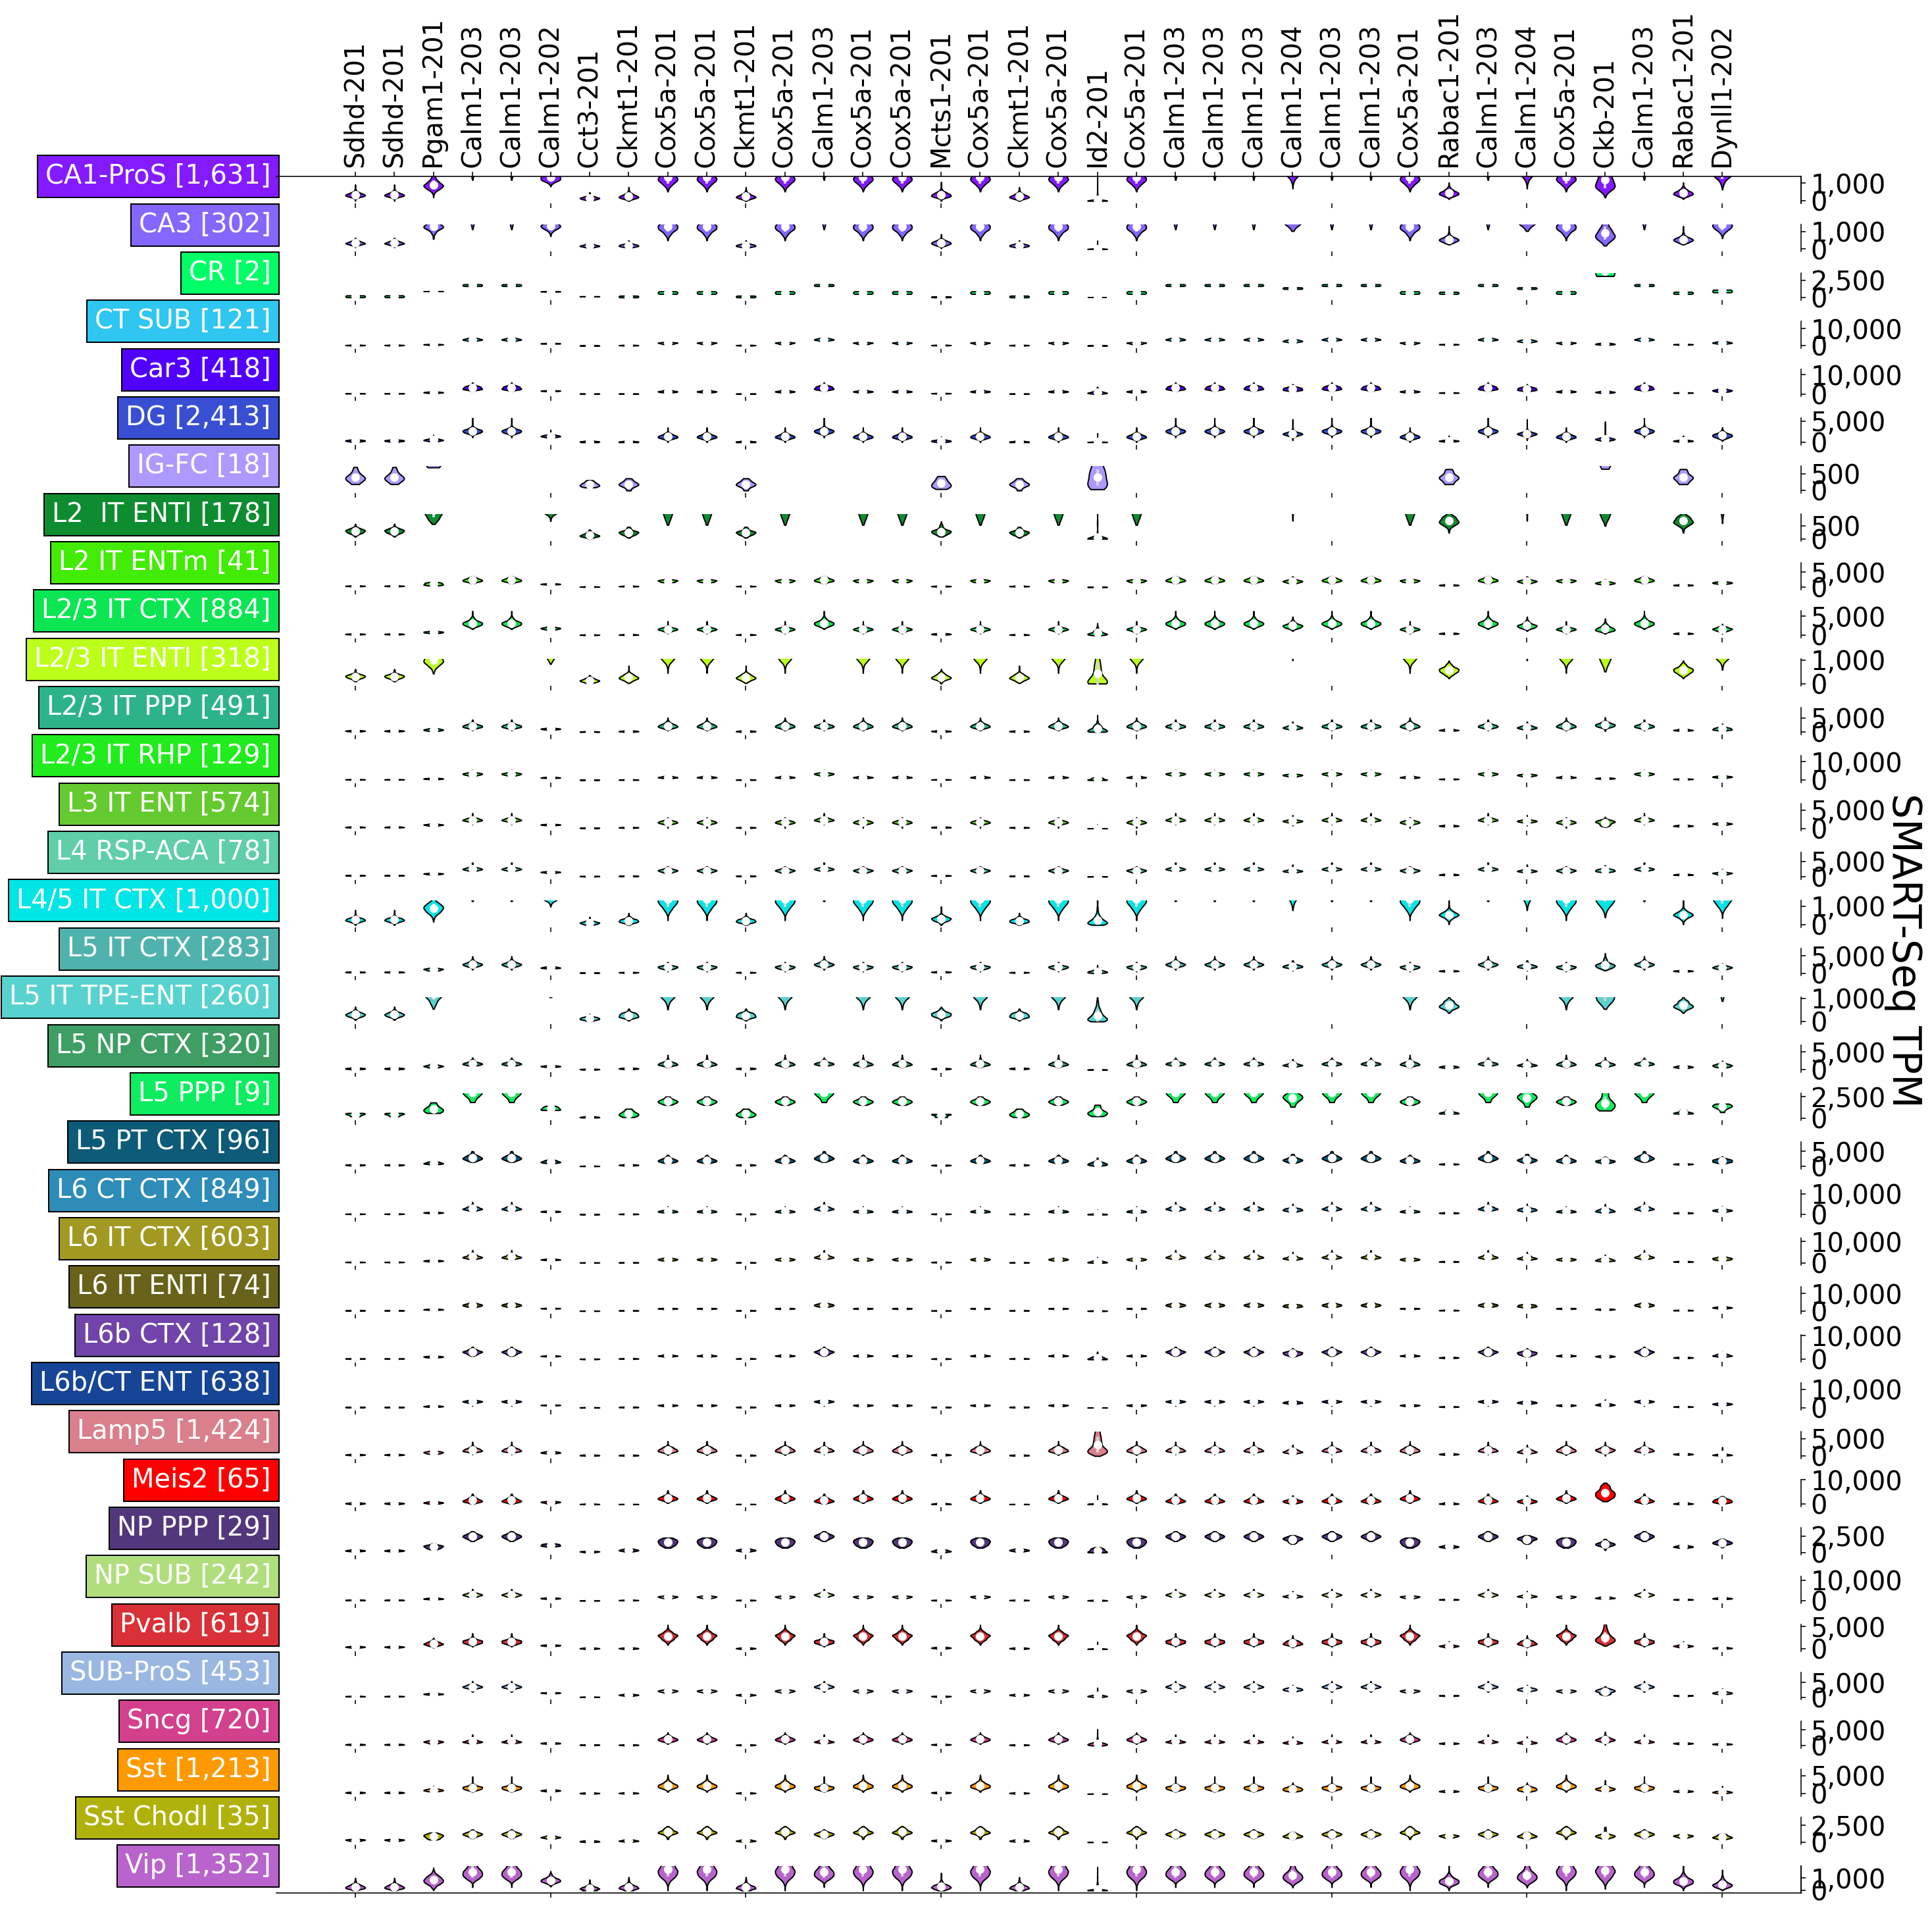

In [58]:
# unique = np.unique(gene.obs.subclass_label)
# unique = np.delete(unique, np.where(unique=="Low Quality"))
#unique = np.array(subclass_order)
unique = np.array(list(marker_map.keys()))
fig, axs = plt.subplots(figsize=(20,20), nrows=len(unique))
fig.subplots_adjust(wspace=0, hspace=0)


labels = top_name
lidx = np.arange(0, len(top_idx), 1)
means = []

for cidx, (c, ax) in enumerate(zip(unique, axs)):
    tmp_mat = mat[obs.subclass_label==c,:]
    
    x = tmp_mat[:,top_idx]
    means.append(nd(np.median(x,axis=0)))

    v = ax.violinplot(x.T.tolist(), showmedians=False, showextrema=False, positions=lidx)

    for pcidx, pc in enumerate(v['bodies']):
        pc.set_facecolor(subclass_cmap[c])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        #pc.set_facecolor('#D43F3A')
        

    means = [np.mean(i) for i in x.T]
    stdevs = np.array([np.sqrt(np.var(i)) for i in x.T])
    ax.vlines(lidx, nd(means) - stdevs, nd(means)+stdevs, color='lightgrey', linestyle='-', lw=2, zorder=9)
    ax.scatter(lidx, means, marker='o', color='white', s=30, zorder=10)
 
    if cidx==0:
        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(lidx)
        ax_top.set_xticklabels(labels, rotation=90, ha="center")
        ax_top.spines["top"].set_visible(True)
        ax_top.spines["left"].set_visible(False)
        ax_top.spines["bottom"].set_visible(False)
    if cidx == len(unique)-1:
        ax_bot = ax.twiny()
        ax_bot.set_xticks([])
        ax_bot.set_xticklabels([])
        ax_bot.spines["top"].set_visible(False)
        ax_bot.spines["left"].set_visible(False)
        ax_bot.spines["bottom"].set_visible(True)

    ax.set_xticklabels("")
    ax.yaxis.tick_right()
    ax.set_ylabel("{} [{:,}]".format(c, x.shape[0]), color="white",rotation="horizontal", ha="right",bbox=dict(boxstyle="square",ec="black",fc=subclass_cmap[c]))
    

    
    lim = nd(x.mean(axis=0))[cidx]*4
    
    ax.set_ylim(-lim*0.1, lim)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

        
    
    

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.text(1, 0.5, 'SMART-Seq TPM ', ha='center', va='center', rotation=270, fontsize=30)
plt.savefig("../../figures/isoform_atlas_violin.png", bbox_inches='tight', dpi=300)
plt.show()

In [59]:
np.array(subclass_order)

array(['L5/6 NP', 'L5 PT', 'L2/3 IT', 'L6b', 'L6 IT', 'L6 CT',
       'L6 IT Car3', 'Lamp5', 'Sncg', 'Vip', 'Sst', 'Pvalb'], dtype='<U10')

# Heatplot

In [60]:
np.array(list(marker_map.keys()))

array(['CA1-ProS', 'CA3', 'CR', 'CT SUB', 'Car3', 'DG', 'IG-FC',
       'L2  IT ENTl', 'L2 IT ENTm', 'L2/3 IT CTX', 'L2/3 IT ENTl',
       'L2/3 IT PPP', 'L2/3 IT RHP', 'L3 IT ENT', 'L4 RSP-ACA',
       'L4/5 IT CTX', 'L5 IT CTX', 'L5 IT TPE-ENT', 'L5 NP CTX', 'L5 PPP',
       'L5 PT CTX', 'L6 CT CTX', 'L6 IT CTX', 'L6 IT ENTl', 'L6b CTX',
       'L6b/CT ENT', 'Lamp5', 'Meis2', 'NP PPP', 'NP SUB', 'Pvalb',
       'SUB-ProS', 'Sncg', 'Sst', 'Sst Chodl', 'Vip'], dtype='<U13')

In [61]:
unique = np.array(subclass_order)

labels = top_name
lidx = np.arange(0, len(top_idx), 1)
means = np.zeros((len(unique), len(top_idx)))

for cidx, c in enumerate(unique):
    tmp_mat = mat[obs.subclass_label==c,:]
    
    x = tmp_mat[:,top_idx]
    m = nd(np.mean(x,axis=0))
    means[cidx,:]= m/m.sum()

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

NameError: name 'trackfig' is not defined

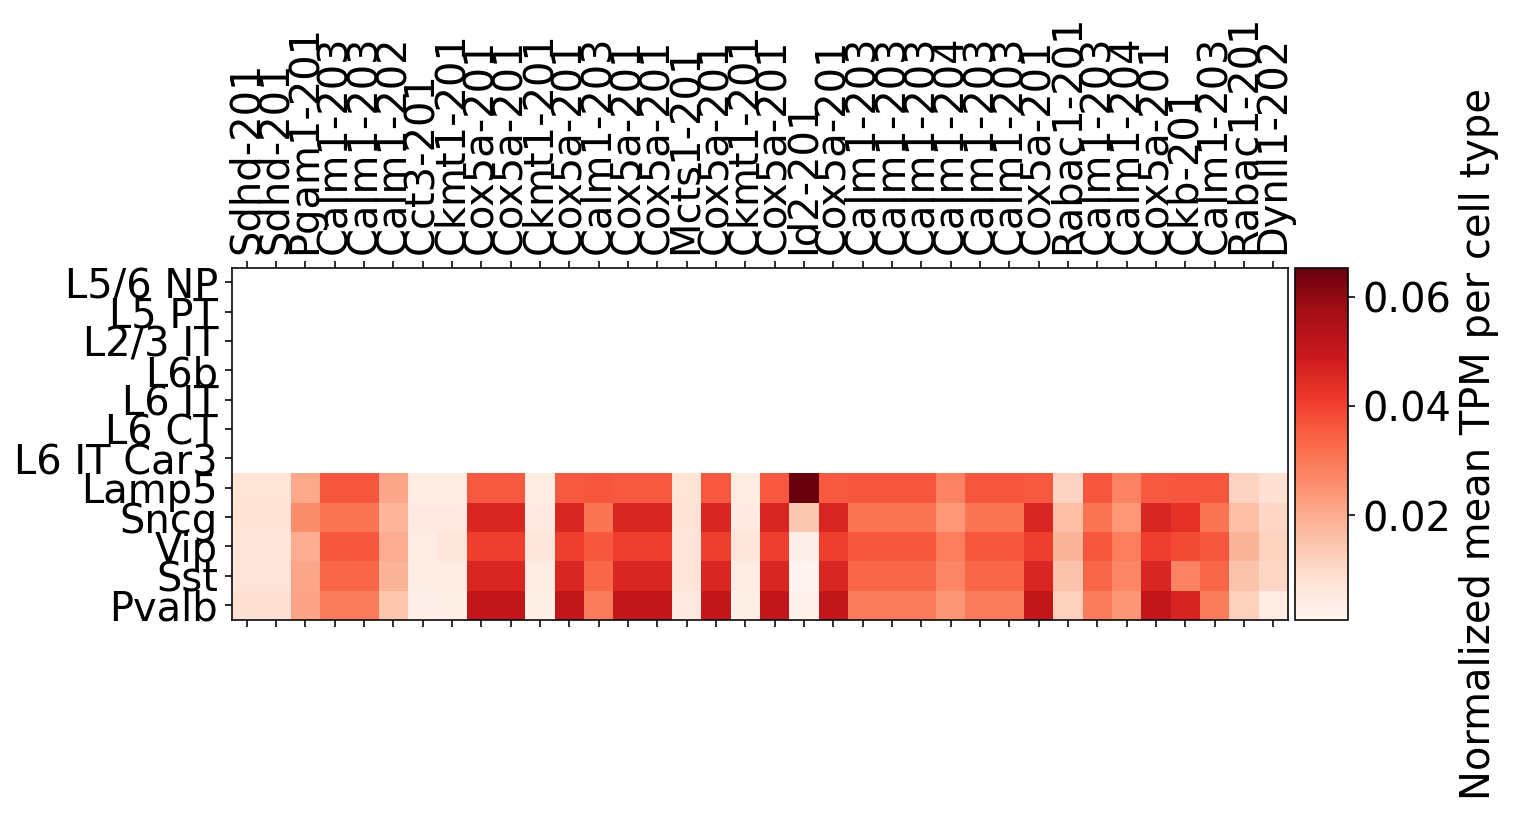

In [63]:
fig, ax = plt.subplots(figsize=(10,10))

ms = ax.matshow(means, cmap="Reds")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(ms, cax=cax, label="Normalized mean TPM per cell type", orientation="vertical")

ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.set_yticks(range(len(unique)))
ax.set_yticklabels(unique)

plt.savefig(trackfig("../../figures/isoform_atlas_heatmap.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)

fig.show()